## Import libraries

In [101]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import gc
import json
import time
from tensorflow.keras.models import load_model

In [102]:
## For CPU only use

USE_CPU_ONLY = True 

if USE_CPU_ONLY:
    print("\n[STABILITY MODE] Disabling GPU to prevent Metal compilation hangs...")
    tf.config.set_visible_devices([], 'GPU')
else:
    # Re-adding the memory growth code for when GPU is enabled
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("[GPU MODE] Memory growth enabled.")
        except RuntimeError as e:
            print(f"Memory growth setting failed: {e}")


[STABILITY MODE] Disabling GPU to prevent Metal compilation hangs...


## Import data files

In [103]:
## Read general meadian file
global_median = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/general_rnn_medians.csv')

In [104]:
global_median.head()
print(global_median.columns)
print(global_median.shape)

Index(['Unnamed: 0', 'is_weekend', 'in_battery_saver_mode', 'charging_status',
       'screen_on', 'dist_from_home', 'is_phone_locked', 'last_phone_usage',
       'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min',
       'days_in_study', 'completion_24h', 'completion_1h',
       'time_between_prompts', 'time_since_last_answered',
       'completion_since_wake', 'completion_since_start',
       'time_of_day_Afternoon', 'time_of_day_Early Morning',
       'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning',
       'time_of_day_Night', 'location_category_Home',
       'location_category_Other', 'location_category_School',
       'location_category_Transit', 'location_category_Work',
       'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0',
       'wake_day_part_3.0'],
      dtype='object')
(1, 33)


In [ ]:
## Read the global means file
global_means = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/global_means_general_rnn.csv')
global_means.head()
print(global_means.columns)
print(global_means.shape)

Index(['Unnamed: 0', 'dist_from_home', 'last_phone_usage',
       'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min',
       'completion_24h', 'completion_1h', 'time_between_prompts',
       'time_since_last_answered', 'completion_since_wake',
       'completion_since_start'],
      dtype='object')
(1, 12)


In [106]:
global_means

,Unnamed: 0,dist_from_home,last_phone_usage,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,completion_24h,completion_1h,time_between_prompts,time_since_last_answered,completion_since_wake,completion_since_start
0,global_mean,26.758968,20.221428,450.684061,499.838291,46.112531,0.757542,0.738929,47.15425,145.570644,0.692321,0.710762


In [107]:
## Read the withdrew processed features file
withdrew_features = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_withdrew.csv')
print(withdrew_features.shape)
withdrew_features.head()

(235071, 66)


,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,ambushdollhousegenerous@timestudy_com,0,0,0.0,1.0,0,0.060436,1.0,11.1,980.950000,...,0,0,0,0,0,0,0,0,0,0
1,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,0.059622,0.0,0.0,830.900000,...,0,0,0,0,0,0,0,0,0,0
2,ambushdollhousegenerous@timestudy_com,1,0,NaN,NaN,1,0.042405,0.0,0.0,487.783333,...,0,0,0,0,0,0,0,0,0,0
3,ambushdollhousegenerous@timestudy_com,0,0,0.0,1.0,1,0.008069,0.0,0.0,242.950000,...,0,0,0,0,0,0,0,0,0,0
4,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,0.059189,0.0,0.0,186.583333,...,0,0,0,0,0,0,0,0,0,0


In [108]:
withdrew_features.columns

Index(['participant_id', 'outcome', 'is_weekend', 'in_battery_saver_mode',
       'charging_status', 'screen_on', 'dist_from_home', 'is_phone_locked',
       'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
       'mims_5min', 'days_in_study', 'completion_24h', 'completion_1h',
       'time_between_prompts', 'time_since_last_answered',
       'completion_since_wake', 'completion_since_start',
       'time_of_day_Afternoon', 'time_of_day_Early Morning',
       'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning',
       'time_of_day_Night', 'location_category_Home',
       'location_category_Other', 'location_category_School',
       'location_category_Transit', 'location_category_Work',
       'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0',
       'wake_day_part_3.0', 'mi_is_weekend', 'mi_in_battery_saver_mode',
       'mi_charging_status', 'mi_screen_on', 'mi_dist_from_home',
       'mi_is_phone_locked', 'mi_last_phone_usage',
 

In [109]:
## Get the max value of days_in_study column for each user as a dataframe
max_days_df = withdrew_features.groupby('participant_id')['days_in_study'].max().reset_index()
max_days_df.rename(columns={'days_in_study': 'max_days_in_study'}, inplace=True)
max_days_df

,participant_id,max_days_in_study
0,ambushdollhousegenerous@timestudy_com,0.273973
1,anywaymustinesspushiness@timestudy_com,0.043836
2,bottledeskworkrequire@timestudy_com,0.304110
3,browsingfrisbeepersevere@timestudy_com,0.213699
4,buckedstiflestagnant@timestudy_com,0.567123
5,busybodyestimatesensitize@timestudy_com,0.002740
6,civicexcludingbarcode@timestudy_com,0.060274
7,cladlandscapeheave@timestudy_com,0.035616
8,confrontcaresssullen@timestudy_com,0.616438
9,deitymagnifierdrove@timestudy_com,0.821918


## Impute missing data
Using fillforward + global median

In [110]:
def impute_within_participant(withdrew_df, global_median, id_col='participant_id'):
    """Impute missing values by forward-filling within each participant.

    - Skips columns starting with "mi_".
    - Excludes `id_col` and outcome columns (`outcome`, `outcomes`).
    - If the first observation for a participant is NaN, fills it using `global_median`.

    Args:
        withdrew_df (pd.DataFrame): input features dataframe (observations ordered per participant).
        global_median (pd.Series or pd.DataFrame): mapping of column -> median value.
        id_col (str): participant id column name (default: 'participant_id').

    Returns:
        pd.DataFrame: imputed copy of `withdrew_df`.
    """
    import pandas as pd
    import numpy as np

    if id_col not in withdrew_df.columns:
        raise ValueError(f"id_col '{id_col}' not found in withdrew_df columns")

    df = withdrew_df.copy()

    # Exclude participant id and outcome columns (case-insensitive)
    exclude = {id_col.lower(), 'outcome', 'outcomes'}

    # Build list of columns to impute
    cols_to_impute = [c for c in df.columns if (c.lower() not in exclude) and (not c.lower().startswith('mi_'))]

    # Forward-fill within each participant
    try:
        df[cols_to_impute] = df.groupby(id_col, sort=False)[cols_to_impute].ffill()
    except Exception:
        # Fallback if grouping/ffill fails for mixed dtypes
        df[cols_to_impute] = df.groupby(id_col, sort=False)[cols_to_impute].apply(lambda g: g.ffill())

    # Helper to extract median from global_median (Series or DataFrame)
    def _get_global_median(col):
        try:
            if isinstance(global_median, pd.Series):
                return global_median.get(col, np.nan)
            if isinstance(global_median, pd.DataFrame):
                # If column exists as DataFrame column, take its first non-null
                if col in global_median.columns:
                    vals = global_median[col].dropna().values
                    if len(vals) > 0:
                        return vals[0]
                # If index contains column names and there's a 'median' column
                if 'median' in global_median.columns and col in global_median.index:
                    return global_median.loc[col, 'median']
                # If index contains column names, return first non-null in that row
                if col in global_median.index:
                    row = global_median.loc[col]
                    if hasattr(row, 'dropna'):
                        vals = row.dropna().values
                        if len(vals) > 0:
                            return vals[0]
        except Exception:
            pass
        return np.nan

    # Fill remaining NaNs (leading NaNs) with global median (or df median as fallback)
    for col in cols_to_impute:
        if df[col].isna().any():
            med = _get_global_median(col)
            if pd.isna(med):
                try:
                    med = df[col].median(skipna=True)
                except Exception:
                    med = np.nan
            if pd.notna(med):
                df[col] = df[col].fillna(med)

    return df


In [111]:
withdrew_features = impute_within_participant(withdrew_features, global_median, id_col='participant_id')
withdrew_features.columns
withdrew_features.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,ambushdollhousegenerous@timestudy_com,0,0,0.0,1.0,0,0.060436,1.0,11.1,980.950000,...,0,0,0,0,0,0,0,0,0,0
1,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,0.059622,0.0,0.0,830.900000,...,0,0,0,0,0,0,0,0,0,0
2,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,0.042405,0.0,0.0,487.783333,...,0,0,0,0,0,0,0,0,0,0
3,ambushdollhousegenerous@timestudy_com,0,0,0.0,1.0,1,0.008069,0.0,0.0,242.950000,...,0,0,0,0,0,0,0,0,0,0
4,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,0.059189,0.0,0.0,186.583333,...,0,0,0,0,0,0,0,0,0,0


## Z-normalization
Using the global mean from pre-training

In [112]:
def z_normalize_within_participant(withdrew_df, global_means, id_col='participant_id', cols=None):
    """Z-normalize selected features using provided global_means.

    - Only normalizes columns in `cols` (defaults to the list requested).
    - Skips `participant_id` and outcome columns.
    - Uses `global_means` to obtain per-column means. For std, tries to read from
      `global_means` (column 'std' or a 'std' entry) and falls back to the column std
      computed from `withdrew_df` if unavailable.
    - The normalization is applied grouped by `id_col` (i.e., transform per participant),
      but uses global mean/std values for scaling.

    Args:
        withdrew_df (pd.DataFrame): input dataframe containing features.
        global_means (pd.Series or pd.DataFrame): mapping of column -> mean (and optionally std).
        id_col (str): participant id column name.
        cols (list[str] | None): list of columns to normalize. If None, uses the default set.

    Returns:
        pd.DataFrame: a copy of `withdrew_df` with selected columns z-normalized.
    """
    import pandas as pd
    import numpy as np

    default_cols = [
        'dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
        'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts',
        'time_since_last_answered', 'completion_since_wake', 'completion_since_start'
    ]
    if cols is None:
        cols = default_cols

    if id_col not in withdrew_df.columns:
        raise ValueError(f"id_col '{id_col}' not found in withdrew_df columns")

    df = withdrew_df.copy()

    # Exclude id and outcome columns explicitly
    exclude = {id_col.lower(), 'outcome', 'outcomes'}
    cols_to_scale = [c for c in cols if (c in df.columns) and (c.lower() not in exclude)]

    def _get_mean(col):
        try:
            if isinstance(global_means, pd.Series):
                return global_means.get(col, np.nan)
            if isinstance(global_means, pd.DataFrame):
                # If there's a 'mean' column and index contains column names
                if 'mean' in global_means.columns and col in global_means.index:
                    return global_means.loc[col, 'mean']
                # If the DataFrame has the feature as a column, take first non-null
                if col in global_means.columns:
                    vals = global_means[col].dropna().values
                    if len(vals) > 0:
                        return vals[0]
                # If index contains col and any column present, take first non-null in the row
                if col in global_means.index:
                    row = global_means.loc[col]
                    if hasattr(row, 'dropna'):
                        vals = row.dropna().values
                        if len(vals) > 0:
                            return vals[0]
        except Exception:
            pass
        return np.nan

    def _get_std(col):
        try:
            if isinstance(global_means, pd.DataFrame):
                if 'std' in global_means.columns and col in global_means.index:
                    return global_means.loc[col, 'std']
                # If std is provided as a column named like '<col>_std'
                std_col = f"{col}_std"
                if std_col in global_means.columns:
                    vals = global_means[std_col].dropna().values
                    if len(vals) > 0:
                        return vals[0]
            # if global_means is a Series containing tuples or dicts, skip
        except Exception:
            pass
        # Fallback: compute std from withdrew_df
        try:
            s = df[col].std(skipna=True)
            if pd.notna(s) and s > 0:
                return s
        except Exception:
            pass
        return np.nan

    for col in cols_to_scale:
        mean = _get_mean(col)
        std = _get_std(col)
        if pd.isna(mean):
            # fallback to column mean from df
            try:
                mean = df[col].mean(skipna=True)
            except Exception:
                mean = 0.0
        if pd.isna(std) or std == 0:
            std = 1.0
        # apply transform grouped by participant (uses same mean/std for all groups)
        df[col] = df.groupby(id_col, sort=False)[col].transform(lambda x, m=mean, s=std: (x - m) / s)

    return df


In [113]:
withdrew_features = z_normalize_within_participant(withdrew_features, global_means, id_col='participant_id')
withdrew_features.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,ambushdollhousegenerous@timestudy_com,0,0,0.0,1.0,0,-0.160718,1.0,-0.413376,1.961272,...,0,0,0,0,0,0,0,0,0,0
1,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,-0.160723,0.0,-0.916420,1.406289,...,0,0,0,0,0,0,0,0,0,0
2,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,-0.160827,0.0,-0.916420,0.137218,...,0,0,0,0,0,0,0,0,0,0
3,ambushdollhousegenerous@timestudy_com,0,0,0.0,1.0,1,-0.161034,0.0,-0.916420,-0.768337,...,0,0,0,0,0,0,0,0,0,0
4,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,-0.160726,0.0,-0.916420,-0.976818,...,0,0,0,0,0,0,0,0,0,0


## Keep only relevant columns
We only keep columns used for training

In [114]:
## read column list .txt file
with open('/Users/adityaponnada/Downloads/time_study_data/processed_feature_columns.txt', 'r') as f:
    column_list = [line.strip() for line in f if line.strip()]


In [115]:
print(column_list)
print(len(column_list))

['participant_id', 'outcome', 'is_weekend', 'in_battery_saver_mode', 'charging_status', 'screen_on', 'dist_from_home', 'is_phone_locked', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'days_in_study', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start', 'time_of_day_Afternoon', 'time_of_day_Early Morning', 'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning', 'time_of_day_Night', 'location_category_Home', 'location_category_Other', 'location_category_School', 'location_category_Transit', 'location_category_Work', 'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0', 'wake_day_part_3.0', 'mi_in_battery_saver_mode', 'mi_charging_status', 'mi_dist_from_home', 'mi_is_phone_locked', 'mi_last_phone_usage', 'mi_closeness_to_sleep_time', 'mi_closeness_to_wake_time', 'mi_mims_5min']
42


In [116]:
## keep only those columns in withdrew_features
withdrew_features = withdrew_features[column_list]
withdrew_features.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,ambushdollhousegenerous@timestudy_com,0,0,0.0,1.0,0,-0.160718,1.0,-0.413376,1.961272,...,0,0,0,0,0,0,0,0,0,0
1,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,-0.160723,0.0,-0.916420,1.406289,...,0,0,0,0,0,0,0,0,0,1
2,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,-0.160827,0.0,-0.916420,0.137218,...,1,0,1,1,0,0,0,0,0,1
3,ambushdollhousegenerous@timestudy_com,0,0,0.0,1.0,1,-0.161034,0.0,-0.916420,-0.768337,...,0,1,0,0,0,0,0,0,0,1
4,ambushdollhousegenerous@timestudy_com,1,0,0.0,0.0,1,-0.160726,0.0,-0.916420,-0.976818,...,0,1,0,0,0,0,0,0,0,1


In [117]:
withdrew_features.shape

(235071, 42)

In [118]:
withdrew_features['participant_id'].nunique()

58

## Prepare tensors

In [119]:
## Get the number of observations per participant_id ordered by highest to lowest
withdrew_features['participant_id'].value_counts().sort_values(ascending=False)

participant_id
orbsquackysyllabuses@timestudy_com           12458
palmbuggystole@timestudy_com                 10857
lizardcauterizepreplan@timestudy_com          9705
ropetinworkdemote@timestudy_com               8666
skipperdropdowncrawlers@timestudy_com         8317
hacksawscoldingdares@timestudy_com            8228
shadilymanholegreeter@timestudy_com           7933
confrontcaresssullen@timestudy_com            7809
skydiverworriercarton@timestudy_com           7728
smeltingexerciserstabilize@timestudy_com      7577
deitymagnifierdrove@timestudy_com             7477
buckedstiflestagnant@timestudy_com            7286
riftchaosdipper@timestudy_com                 7067
dimmeddismaylegume@timestudy_com              6180
hazingdiscolorsuffering@timestudy_com         5815
rankingkindnessspindle@timestudy_com          5722
lappedvastlydebating@timestudy_com            5487
iodinegrapemonstrous@timestudy_com            5281
itunesgurgleexchange@timestudy_com            5177
euphemismfederal

In [120]:
# --- 1. GLOBAL CONSTANTS ---
L_CHUNK = 3967
NUM_CHUNKS = 4
MAX_TOTAL_STEPS = L_CHUNK * NUM_CHUNKS  # 15,868
SENTINEL_VALUE = 999.0
NUM_FEATURES = 40

In [121]:
def convert_to_4d_tensors(df):
    """
    Converts a pre-scaled/imputed DataFrame into 4D tensors.
    Logic is identical for both Setup 1 and Setup 2.
    """
    print(f"Processing {len(df['participant_id'].unique())} participants...")
    
    X_list = []
    Y_list = []
    participant_ids = []

    # Ensure the dataframe is sorted by participant and time (if applicable)
    # Group by participant to keep sequences intact
    grouped = df.groupby('participant_id')

    for p_id, group in grouped:
        participant_ids.append(p_id)
        
        # 1. Extract Features (X)
        # Drop metadata columns to leave only the 40 features
        x_features = group.drop(columns=['participant_id', 'outcome']).values
        
        # 2. Extract Labels (Y)
        y_labels = group['outcome'].values.astype('float32').reshape(-1, 1)
        
        X_list.append(x_features)
        Y_list.append(y_labels)

    # 3. Padding
    # pad_sequences handles users who withdrew early (shorter than 15,868 steps)
    # 'post' padding ensures the actual behavior is at the start, and sentinel values are at the end
    print("Padding sequences to 15,868 steps...")
    X_padded = pad_sequences(
        X_list, 
        maxlen=MAX_TOTAL_STEPS, 
        padding='post', 
        dtype='float32', 
        value=SENTINEL_VALUE
    )
    
    Y_padded = pad_sequences(
        Y_list, 
        maxlen=MAX_TOTAL_STEPS, 
        padding='post', 
        dtype='float32', 
        value=SENTINEL_VALUE
    )

    # 4. Reshaping to 4D (N, Chunks, L_Chunk, Features)
    num_participants = len(participant_ids)
    
    print(f"Reshaping into 4D tensors...")
    X_4d = X_padded.reshape(num_participants, NUM_CHUNKS, L_CHUNK, NUM_FEATURES)
    Y_4d = Y_padded.reshape(num_participants, NUM_CHUNKS, L_CHUNK, 1)

    # 5. Convert to TF Tensors
    X_tensor = tf.cast(X_4d, tf.float32)
    Y_tensor = tf.cast(Y_4d, tf.float32)

    print(f"Final X Shape: {X_tensor.shape}") # (N, 4, 3967, 40)
    print(f"Final Y Shape: {Y_tensor.shape}") # (N, 4, 3967, 1)
    
    return X_tensor, Y_tensor, participant_ids

In [122]:
X_withdrawn_s1, Y_withdrawn_s1, p_ids = convert_to_4d_tensors(withdrew_features)

Processing 58 participants...
Padding sequences to 15,868 steps...
Reshaping into 4D tensors...
Final X Shape: (58, 4, 3967, 40)
Final Y Shape: (58, 4, 3967, 1)


In [123]:
def calculate_burden_thresholds(X_tensor, Y_tensor, participant_ids, days_col='days_in_study', feature_columns=None, sentinel=999.0):
    """
    Calculates the 'Burden Tolerance Threshold' and 'Burden Velocity' 
    for each withdrawn participant using column names.
    
    Args:
        X_tensor: 4D Tensor (N, 4, 3967, D)
        Y_tensor: 4D Tensor (N, 4, 3967, 1)
        participant_ids: List of participant IDs
        days_col: String name of the column (e.g., 'days_in_study') or integer index.
        feature_columns: The list of feature names used to create X_tensor.
        sentinel: The padding value (999.0).
    """
    # 1. Resolve column name to index
    if isinstance(days_col, str):
        if feature_columns is None:
            raise ValueError("You must provide 'feature_columns' list to use a column name string.")
        try:
            days_idx = list(feature_columns).index(days_col)
            print(f"Resolved '{days_col}' to index {days_idx}")
        except ValueError:
            raise ValueError(f"Column '{days_col}' not found in provided feature_columns.")
    else:
        days_idx = days_col

    threshold_results = []
    X_np = X_tensor.numpy() if hasattr(X_tensor, 'numpy') else X_tensor
    Y_np = Y_tensor.numpy() if hasattr(Y_tensor, 'numpy') else Y_tensor
    
    print(f"Calculating thresholds for {len(participant_ids)} users...")

    # --- DIAGNOSTIC: FEATURE SCAN ---
    print("\n" + "-"*30)
    print("      DIAGNOSTIC: FEATURE SCAN (User 1)")
    print("-"*30)
    x_first_user = X_np[0].reshape(-1, X_np.shape[-1])
    y_first_user = Y_np[0].flatten()
    valid_mask_first = (np.abs(y_first_user - sentinel) > 0.1)
    clean_x_first = x_first_user[valid_mask_first]
    
    for col in range(min(10, clean_x_first.shape[1])):
        name = feature_columns[col] if feature_columns is not None else f"Col {col}"
        col_data = clean_x_first[:, col]
        actual_data = col_data[np.abs(col_data - sentinel) > 0.1]
        if len(actual_data) > 0:
            print(f"{name:15} | Max: {np.max(actual_data):.6f}")
    print("-"*30 + "\n")

    for i, p_id in enumerate(participant_ids):
        y_user_flat = Y_np[i].flatten()
        valid_mask = (np.abs(y_user_flat - sentinel) > 0.1)
        y_actual = y_user_flat[valid_mask]
        
        busy_moments = np.sum(y_actual == 0.0)
        
        x_user_flat = X_np[i].reshape(-1, X_np.shape[-1])
        x_actual_features = x_user_flat[valid_mask]
        
        scaled_days = x_actual_features[:, days_idx]
        clean_scaled_days = scaled_days[np.abs(scaled_days - sentinel) > 0.1]
        
        if len(clean_scaled_days) > 0:
            max_scaled_day = np.max(clean_scaled_days)
            actual_days_raw = max_scaled_day * 365.0
        else:
            actual_days_raw = 1.0 
            
        actual_days_in_study = np.maximum(1.0, actual_days_raw)
        intrusive_velocity = busy_moments / actual_days_in_study
        
        threshold_results.append({
            'participant_id': p_id,
            'burden_threshold': int(busy_moments),
            'actual_days_in_study': round(float(actual_days_in_study), 2),
            'intrusive_velocity_per_day': float(intrusive_velocity)
        })

    df_thresholds = pd.DataFrame(threshold_results)
    
    print("\n" + "="*50)
    print("      BURDEN & ATTRITION VELOCITY SUMMARY")
    print("="*50)
    print(f"Mean Threshold: {df_thresholds['burden_threshold'].mean():.1f} pings")
    print(f"Mean Duration:  {df_thresholds['actual_days_in_study'].mean():.1f} days")
    print("="*50)
    
    return df_thresholds

In [124]:
my_features = withdrew_features.drop(columns=['participant_id', 'outcome']).columns.tolist()

In [125]:
df_breaking_points = calculate_burden_thresholds(
    X_withdrawn_s1, Y_withdrawn_s1, p_ids, 
    days_col='days_in_study', 
    feature_columns=my_features)
df_breaking_points.to_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_thresholds.csv', index=False)

Resolved 'days_in_study' to index 10
Calculating thresholds for 58 users...

------------------------------
      DIAGNOSTIC: FEATURE SCAN (User 1)
------------------------------
is_weekend      | Max: 1.000000
in_battery_saver_mode | Max: 1.000000
charging_status | Max: 1.000000
screen_on       | Max: 1.000000
dist_from_home  | Max: -0.022700
is_phone_locked | Max: 1.000000
last_phone_usage | Max: 1.802735
closeness_to_sleep_time | Max: 2.571551
closeness_to_wake_time | Max: 2.770318
mims_5min       | Max: 5.394656
------------------------------


      BURDEN & ATTRITION VELOCITY SUMMARY
Mean Threshold: 882.5 pings
Mean Duration:  122.6 days


In [126]:
df_breaking_points

,participant_id,burden_threshold,actual_days_in_study,intrusive_velocity_per_day
0,ambushdollhousegenerous@timestudy_com,958,100.0,9.580000
1,anywaymustinesspushiness@timestudy_com,33,16.0,2.062500
2,bottledeskworkrequire@timestudy_com,662,111.0,5.963964
3,browsingfrisbeepersevere@timestudy_com,765,78.0,9.807693
4,buckedstiflestagnant@timestudy_com,1643,207.0,7.937198
5,busybodyestimatesensitize@timestudy_com,19,1.0,18.999999
6,civicexcludingbarcode@timestudy_com,212,22.0,9.636364
7,cladlandscapeheave@timestudy_com,110,13.0,8.461538
8,confrontcaresssullen@timestudy_com,1676,225.0,7.448889
9,deitymagnifierdrove@timestudy_com,515,300.0,1.716667


## zero shot simulation

In [132]:
def mask_generator_fn(x):
    import tensorflow as tf
    return tf.cast(tf.not_equal(x[:, :, :1], 999.0), tf.float32)

def optimized_loss_fn(y_true, y_pred):
    import tensorflow as tf
    mask = tf.cast(tf.not_equal(y_true, 999.0), tf.float32)
    y_p = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    bce = - (y_true * tf.math.log(y_p) + (1.0 - y_true) * tf.math.log(1.0 - y_p))
    y_true_int = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)
    weights = tf.gather(tf.constant([0.8, 0.2], dtype=tf.float32), tf.clip_by_value(y_true_int, 0, 1))
    return tf.reduce_sum(bce * tf.expand_dims(weights, -1) * mask) / (tf.reduce_sum(mask) + 1e-7)

def optimized_f1_class0(y_true, y_pred):
    import tensorflow as tf
    mask = tf.cast(tf.not_equal(y_true, 999.0), tf.float32)
    y_t = (1.0 - y_true) * mask
    y_p = (1.0 - tf.math.round(y_pred)) * mask
    tp = tf.reduce_sum(y_t * y_p)
    fp = tf.reduce_sum((1.0 - y_t) * y_p * mask)
    fn = tf.reduce_sum(y_t * (1.0 - y_p) * mask)
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    return 2 * ((precision * recall) / (precision + recall + 1e-7))

In [133]:
from sklearn.metrics import f1_score
def run_zero_shot_simulation(model_path, X_tensor, Y_tensor, participant_ids, threshold=0.43):
    """
    Simulates the burden reduction on withdrawn users using a pre-trained model.
    Also calculates the F1-score for Class 0 (Busy/Non-Response).
    """
    print(f"\nLoading model: {model_path}")
    model = load_model(model_path, custom_objects={
        'optimized_loss_fn': optimized_loss_fn,
        'optimized_f1_class0': optimized_f1_class0,
        'mask_generator_fn': mask_generator_fn,
        'tf': tf
    }, compile=False)

    simulation_results = []
    all_true_agg = []
    all_pred_agg = []

    print(f"Simulating pings for {len(participant_ids)} participants...")

    for i, p_id in enumerate(participant_ids):
        # 1. Predict probabilities (N_chunks, L_chunk, 1)
        probs = model.predict(X_tensor[i:i+1][0], batch_size=1, verbose=0).flatten()
        
        # 2. Extract Ground Truth and Mask
        y_true = Y_tensor[i].numpy().flatten()
        valid_mask = y_true != SENTINEL_VALUE
        
        y_true_real = y_true[valid_mask]
        y_prob_real = probs[valid_mask]
        
        # 3. Model Decision Logic:
        # Pings are sent ONLY if probability of 'Available' (Class 1) > threshold
        pings_sent_mask = y_prob_real > threshold
        y_pred_real = pings_sent_mask.astype(int)
        
        # 4. Calculate Individual F1 for Class 0
        user_f1 = f1_score(y_true_real, y_pred_real, pos_label=0, zero_division=0)
        
        # 5. Record counts for burden analysis
        model_intrusive_pings = np.sum((y_true_real == 0.0) & (pings_sent_mask == True))
        successful_blocks = np.sum((y_true_real == 0.0) & (pings_sent_mask == False))
        total_busy_moments = np.sum(y_true_real == 0.0)

        # 6. Aggregate for overall statistics
        all_true_agg.extend(y_true_real)
        all_pred_agg.extend(y_pred_real)

        simulation_results.append({
            'participant_id': p_id,
            'f1_score_c0': user_f1,
            'model_intrusive_pings': int(model_intrusive_pings),
            'lazy_intrusive_pings': int(total_busy_moments),
            'pings_avoided': int(successful_blocks),
            'reduction_rate': successful_blocks / (total_busy_moments + 1e-7)
        })

    # Summary DataFrame
    df_sim = pd.DataFrame(simulation_results)
    
    # Calculate Overall Metrics
    overall_f1 = f1_score(all_true_agg, all_pred_agg, pos_label=0, zero_division=0)
    avg_reduction = df_sim['reduction_rate'].mean() * 100
    
    print("\n" + "="*50)
    print(f"      SIMULATION SUMMARY: {model_path}")
    print("="*50)
    print(f"Overall F1 (Class 0):      {overall_f1:.4f}")
    print(f"Mean Per-User F1:          {df_sim['f1_score_c0'].mean():.4f}")
    print(f"Average Burden Reduction:  {avg_reduction:.2f}%")
    print("="*50)
    
    return df_sim

In [134]:
df_sim_s1 = run_zero_shot_simulation('best_model_safe.h5', X_withdrawn_s1, Y_withdrawn_s1, p_ids, threshold=0.43)


Loading model: best_model_safe.h5
Simulating pings for 58 participants...

      SIMULATION SUMMARY: best_model_safe.h5
Overall F1 (Class 0):      0.4514
Mean Per-User F1:          0.4258
Average Burden Reduction:  70.06%


In [135]:
df_sim_s1.to_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_simulation_setup1.csv', index=False)    

In [136]:
df_sim_s1

,participant_id,f1_score_c0,model_intrusive_pings,lazy_intrusive_pings,pings_avoided,reduction_rate
0,ambushdollhousegenerous@timestudy_com,0.521739,202,958,756,0.789144
1,anywaymustinesspushiness@timestudy_com,0.135922,19,33,14,0.424242
2,bottledeskworkrequire@timestudy_com,0.383971,341,662,321,0.484894
3,browsingfrisbeepersevere@timestudy_com,0.509105,122,765,643,0.840523
4,buckedstiflestagnant@timestudy_com,0.522926,628,1643,1015,0.617772
5,busybodyestimatesensitize@timestudy_com,0.413793,13,19,6,0.315789
6,civicexcludingbarcode@timestudy_com,0.442804,92,212,120,0.566038
7,cladlandscapeheave@timestudy_com,0.445013,23,110,87,0.790909
8,confrontcaresssullen@timestudy_com,0.365065,50,1676,1626,0.970167
9,deitymagnifierdrove@timestudy_com,0.214286,380,515,135,0.262136


Note that these are important to print for the paper

In [138]:
df_sim_s1['reduction_rate'].mean() * 100

70.06192627342183

In [153]:
df_sim_s1['reduction_rate'].std() * 100

22.493755479267495

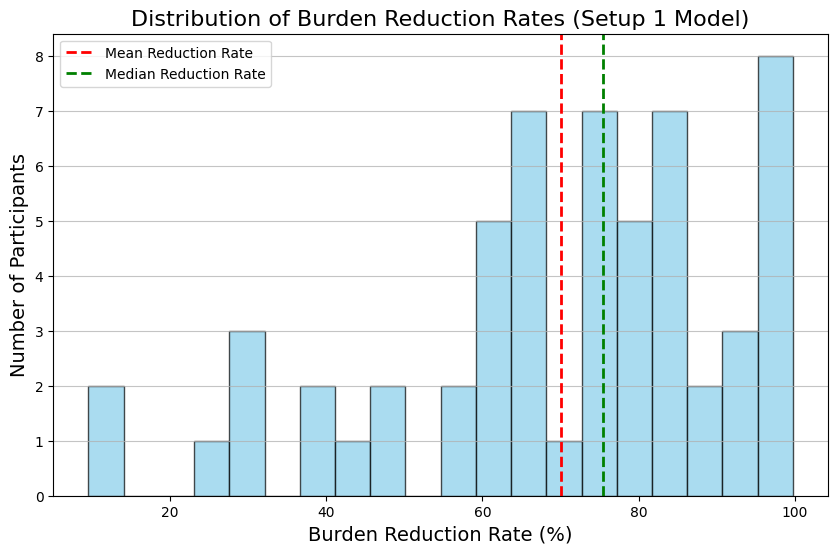

In [137]:
## Plot the distribution of reduction rates with mean and median lines
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_sim_s1['reduction_rate'] * 100, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(df_sim_s1['reduction_rate'].mean() * 100, color='red', linestyle='dashed', linewidth=2, label='Mean Reduction Rate')
plt.axvline(df_sim_s1['reduction_rate'].median() * 100, color='green', linestyle='dashed', linewidth=2, label='Median Reduction Rate')
plt.title('Distribution of Burden Reduction Rates (Setup 1 Model)', fontsize=16)
plt.xlabel('Burden Reduction Rate (%)', fontsize=14)
plt.ylabel('Number of Participants', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

## Compute study survival

In [149]:
def calculate_study_extension(df_thresholds, df_simulation, model_name="Setup 1 Model"):
    """
    Calculates the projected study life for withdrawn participants.
    
    Args:
        df_thresholds: DataFrame from Phase 2 (participant_id, burden_threshold, actual_days_in_study)
        df_simulation: DataFrame from Phase 3 (participant_id, model_intrusive_pings)
        model_name: String label for the results.
    """
    # 1. Merge the Breaking Point data with the Simulation results
    df_combined = pd.merge(df_thresholds, df_simulation, on='participant_id')
    
    results = []
    
    print(f"Calculating study extension for {model_name}...")

    for _, row in df_combined.iterrows():
        p_id = row['participant_id']
        threshold = row['burden_threshold']
        actual_days = row['actual_days_in_study']
        model_pings = row['model_intrusive_pings']
        f1 = row['f1_score_c0']
        
        # 2. Calculate Velocities (Pings per Day)
        # Velocity Lazy: How fast they hit the breaking point in reality
        v_lazy = threshold / actual_days
        
        # Velocity Model: How fast they would have hit it with the app
        v_model = model_pings / actual_days
        
        # 3. Project Extended Life
        # Formula: Threshold / New Velocity
        if v_model == 0:
            # If the model is so good it sends 0 intrusive pings, they theoretically last forever
            projected_days = 365.0 
        else:
            projected_days = threshold / v_model
        
        # 4. Cap at 365 days (the end of the study duration)
        projected_days_capped = min(365.0, projected_days)
        # projected_days_capped = projected_days
        
        # 5. Check if they "Survive" the full study
        stayed_full_study = 1 if projected_days_capped >= 365.0 else 0
        
        results.append({
            'participant_id': p_id,
            'threshold': threshold,
            'f1':f1,
            'actual_days': actual_days,
            'projected_days': round(projected_days_capped, 2),
            'extension_days': round(projected_days_capped - actual_days, 2),
            'v_lazy': round(v_lazy, 4),
            'v_model': round(v_model, 4),
            'saved_participant': stayed_full_study
        })

    df_final = pd.DataFrame(results)
    
    # --- Summary Metrics ---
    total_users = len(df_final)
    saved_users = df_final['saved_participant'].sum()
    avg_extension = df_final['extension_days'].mean()
    
    print("\n" + "="*50)
    print(f"      COUNTERFACTUAL RESULTS: {model_name}")
    print("="*50)
    print(f"Mean Study Life Extension:    {avg_extension:.1f} days")
    print(f"Participants Saved (Full Yr): {saved_users} out of {total_users} ({saved_users/total_users:.1%})")
    print(f"Burden Velocity Reduction:    {((df_final['v_lazy'].mean() - df_final['v_model'].mean()) / df_final['v_lazy'].mean()):.1%}")
    print("="*50)
    
    return df_final

In [150]:
df_extension_s1 = calculate_study_extension(df_breaking_points, df_sim_s1, model_name="Setup 1")

Calculating study extension for Setup 1...

      COUNTERFACTUAL RESULTS: Setup 1
Mean Study Life Extension:    152.4 days
Participants Saved (Full Yr): 32 out of 58 (55.2%)
Burden Velocity Reduction:    74.5%


In [151]:
df_extension_s1.to_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_study_extension_setup1.csv', index=False)

In [152]:
df_extension_s1

,participant_id,threshold,f1,actual_days,projected_days,extension_days,v_lazy,v_model,saved_participant
0,ambushdollhousegenerous@timestudy_com,958,0.521739,100.0,365.00,265.00,9.5800,2.0200,1
1,anywaymustinesspushiness@timestudy_com,33,0.135922,16.0,27.79,11.79,2.0625,1.1875,0
2,bottledeskworkrequire@timestudy_com,662,0.383971,111.0,215.49,104.49,5.9640,3.0721,0
3,browsingfrisbeepersevere@timestudy_com,765,0.509105,78.0,365.00,287.00,9.8077,1.5641,1
4,buckedstiflestagnant@timestudy_com,1643,0.522926,207.0,365.00,158.00,7.9372,3.0338,1
5,busybodyestimatesensitize@timestudy_com,19,0.413793,1.0,1.46,0.46,19.0000,13.0000,0
6,civicexcludingbarcode@timestudy_com,212,0.442804,22.0,50.70,28.70,9.6364,4.1818,0
7,cladlandscapeheave@timestudy_com,110,0.445013,13.0,62.17,49.17,8.4615,1.7692,0
8,confrontcaresssullen@timestudy_com,1676,0.365065,225.0,365.00,140.00,7.4489,0.2222,1
9,deitymagnifierdrove@timestudy_com,515,0.214286,300.0,365.00,65.00,1.7167,1.2667,1


Note that these are important to print in the code for the paper

In [155]:
df_extension_s1['f1'].mean()

0.42577165787803517

In [156]:
df_extension_s1['f1'].std()

0.15975428542254183

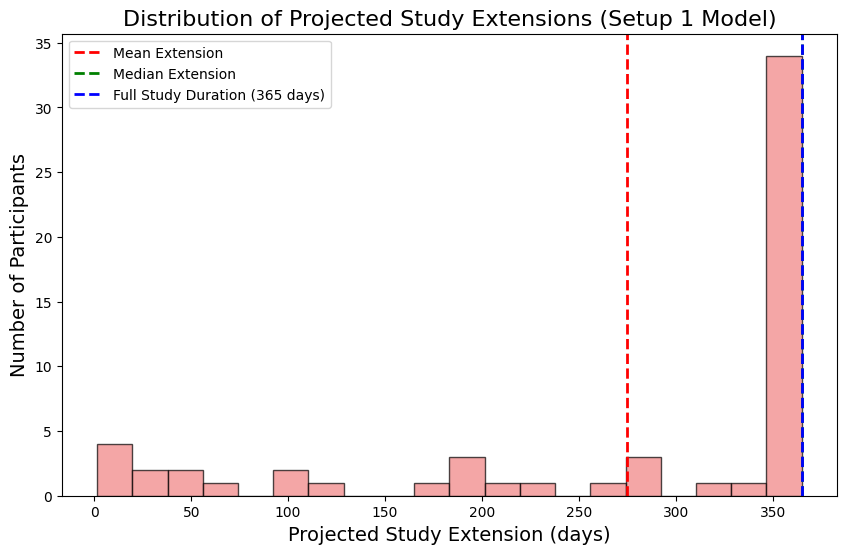

In [144]:
## Plot the distribution of projected study extensions with mean and median lines. Also add a vertical line for 365 days
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_extension_s1['projected_days'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(df_extension_s1['projected_days'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean Extension')
plt.axvline(df_extension_s1['projected_days'].median(), color='green', linestyle='dashed', linewidth=2, label='Median Extension')
plt.axvline(365, color='blue', linestyle='dashed', linewidth=2, label='Full Study Duration (365 days)')
plt.title('Distribution of Projected Study Extensions (Setup 1 Model)', fontsize=16)
plt.xlabel('Projected Study Extension (days)', fontsize=14)
plt.ylabel('Number of Participants', fontsize=14)
plt.legend()

## Compare study survival with prior data

In [145]:
def plot_actual_vs_projected_density(df_extension_s1, actual_col='actual_days', projected_col='projected_days', title=None, figsize=(8,4), kde_kwargs=None):
    """Return a Matplotlib Figure containing two density plots (actual vs projected).

    - df_extension_s1: DataFrame containing the two columns.
    - actual_col: column name for actual days.
    - projected_col: column name for projected days.
    - title: optional plot title.
    - Returns: Matplotlib Figure object.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    if actual_col not in df_extension_s1.columns:
        raise ValueError(f"actual_col '{actual_col}' not found in dataframe")
    if projected_col not in df_extension_s1.columns:
        raise ValueError(f"projected_col '{projected_col}' not found in dataframe")

    kde_kwargs = {} if kde_kwargs is None else dict(kde_kwargs)

    actual = df_extension_s1[actual_col].dropna()
    projected = df_extension_s1[projected_col].dropna()

    fig, ax = plt.subplots(figsize=figsize)

    # compute combined x-limits
    combined = np.concatenate([actual.values if len(actual)>0 else np.array([]), projected.values if len(projected)>0 else np.array([])])
    if combined.size == 0:
        raise ValueError("Both input series are empty after dropping NaNs")
    xmin, xmax = np.nanmin(combined), np.nanmax(combined)
    pad = (xmax - xmin) * 0.05 if xmax > xmin else 1.0
    xmin -= pad; xmax += pad

    sns.kdeplot(actual, ax=ax, label='Actual', fill=True, alpha=0.4, **kde_kwargs)
    sns.kdeplot(projected, ax=ax, label='Projected', fill=True, alpha=0.4, **kde_kwargs)

    # plot vertical lines for means
    actual_mean = actual.mean() if len(actual)>0 else np.nan
    projected_mean = projected.mean() if len(projected)>0 else np.nan
    if np.isfinite(actual_mean):
        ax.axvline(actual_mean, color='C0', linestyle='--', linewidth=1.5)
        ax.text(actual_mean, ax.get_ylim()[1]*0.9, f"μ={actual_mean:.2f}", color='C0', rotation=90, va='top', ha='right')
    if np.isfinite(projected_mean):
        ax.axvline(projected_mean, color='C1', linestyle='--', linewidth=1.5)
        ax.text(projected_mean, ax.get_ylim()[1]*0.8, f"μ={projected_mean:.2f}", color='C1', rotation=90, va='top', ha='right')

    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Days')
    ax.set_ylabel('Density')
    if title:
        ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    return fig


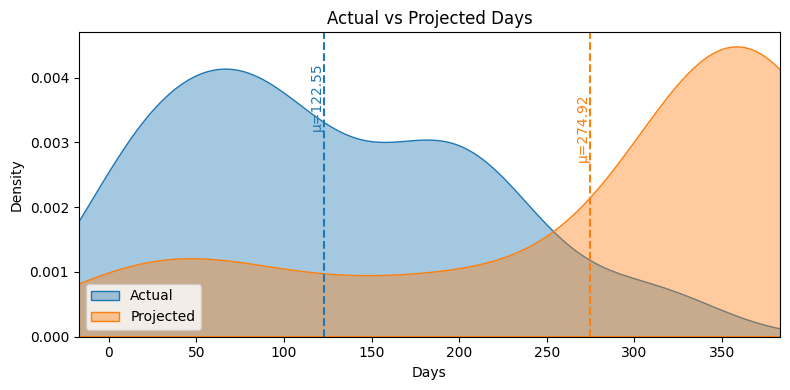

In [146]:
fig = plot_actual_vs_projected_density(df_extension_s1, actual_col='actual_days', projected_col='projected_days', title='Actual vs Projected Days')
fig.savefig('/Users/adityaponnada/Downloads/time_study_data/actual_vs_projected_density_s1.png')